In [43]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [39]:
# define linear algebra functions

def vector_add(v, w):
    # adds corresponding elements
    return [v_i + w_i for v_i, w_i in zip(v, w)]


def vector_subtract(v, w):
    # subtracts corresponding elements
    return [v_i - w_i for v_i, w_i in zip(v, w)]


def vector_sum(vectors):
    # sums all corresponding elements
    result = vectors[0]                       # begin from the 1st vector
    for vector in vectors[1:]:                # go in the loop through the rest of the vectors
        result = vector_add(result, vector)   # and add them to the result
    return result


def scalar_multiply(c, v):
    # multiplies every element by c, c is a number, v is a vector
    return [c * v_i for v_i in v]


def vector_mean(vectors):
    # computes the element-wise average
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))


def dot(v, w):
    # computes v_1 * w_1 + ... + v_n * w_n
    return sum(v_i * w_i for v_i, w_i in zip(v, w))


def sum_of_squares(v):
    # returns v_1 * v_1 + ... + v_n * v_n
    return dot(v, v)


def squared_distance(v, w):
    # computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2
    return sum_of_squares(vector_subtract(v, w))

# Model

In [34]:
class KMeans:
    """performs k-means clustering"""

    def __init__(self, k):
        self.k = k          # number of clusters
        self.means = None   # means of clusters

    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs):

        self.means = random.sample(inputs, self.k)
        assignments = None

        while True:
            # Find new assignments
            new_assignments = list(map(self.classify, inputs))

            # If no assignments have changed, we're done
            if assignments == new_assignments:
                return

            # Otherwise keep the new assignments,
            assignments = new_assignments

            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # avoid divide-by-zero if i_points is empty
                if i_points:
                    self.means[i] = vector_mean(i_points)

# Example: meetups

In [61]:
clusterer = KMeans(3)
clusterer.train(inputs)
print("3-means:", clusterer.means)

3-means: [[-15.888888888888888, -10.333333333333332], [-43.800000000000004, 5.4], [18.333333333333332, 19.833333333333332]]


In [62]:
clusterer = KMeans(2)
clusterer.train(inputs)
print("2-means:", clusterer.means)

2-means: [[-25.857142857142854, -4.714285714285714], [18.333333333333332, 19.833333333333332]]


# K selection

In [35]:
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = list(map(clusterer.classify, inputs))

    return sum(squared_distance(input,means[cluster])
               for input, cluster in zip(inputs, assignments))

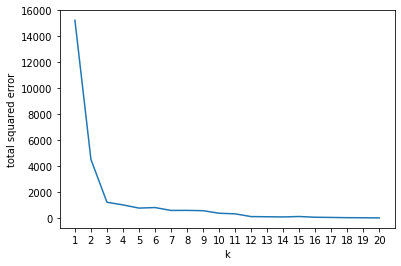

In [65]:
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.show()

# Example: using clustering to recolour an image

In [45]:
path_to_png_file = r"PNG_transparency_demonstration_1.png"
img = mpimg.imread(path_to_png_file)

In [46]:
pixels = [pixel for row in img for pixel in row]
clusterer = KMeans(5)
clusterer.train(pixels) # this might take a while

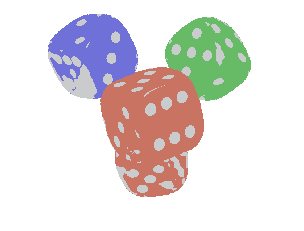

In [47]:
def recolor(pixel):
        cluster = clusterer.classify(pixel) # index of the closest cluster
        return clusterer.means[cluster]     # mean of the closest cluster

new_img = [[recolor(pixel) for pixel in row]
           for row in img]

plt.imshow(new_img)
plt.axis('off')
plt.show()

# Bottom-up method of hierarchical clustering

In [48]:
def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1


def get_children(cluster):
    """returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster"""
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]
    
    
def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster # is already a 1-tuple containing value
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]

In [49]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    """finds the aggregate distance between elements of cluster1
    and elements of cluster2"""
    return distance_agg([distance(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

In [50]:
def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple

In [51]:
def bottom_up_cluster(inputs, distance_agg=min):
    # start with every input a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                     key=lambda p: cluster_distance(p[0], p[1], distance_agg))

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

In [55]:
def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]
        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters